In [2]:
import numpy as np
import sys
import scipy.io as sio  # For reading the matlab .mat format
import pickle as pk
import numpy as np
import pandas as pd
import iisignature as iis
import gudhi
from gudhi import plot_persistence_diagram
from gudhi import plot_persistence_density
from gtda.homology import VietorisRipsPersistence
from gtda.homology import FlagserPersistence
import matplotlib.pyplot as plt
import random
from gtda.diagrams import PersistenceEntropy
from gtda.diagrams import Amplitude
from gudhi.representations.vector_methods import Entropy
from gtda.diagrams import PairwiseDistance
from gtda.plotting import plot_diagram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from scipy.stats import zscore

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# Allora, qui modifico leggermente quanto fatto nel codice originario in cui considero l'estrazione di serie temporali
# dello stesso dataset, innanzitutto non faccio classificazione sulla path signature o su tutta la Lead matrix, poichè 
# data il numero esiguo di persone il problema potrebbe essere mal condizionato.
# Non utilizzerò nemmeno la random forest per lo stesso motivo, proverò a usare invece la cross validation
# usando il "leave one out"

In [4]:
# Load data in .mat format (rows are time instants, columns are ROI, 116 ARE ROIs)
# (THIS IS A SANTORO FUNCTION)
def load_data_mat(path_single_file):
    file_to_open = path_single_file
    data = sio.loadmat(file_to_open)
    key_data = list(data.keys())[-2]
    data = data[key_data]
    return(data)

In [5]:
def lead_matrix_1(mv_time_series):
    N=mv_time_series.shape[1]
    sig=iis.sig(mv_time_series,2)
    S=sig[N:].reshape(N,N)
    L=(S-S.T)/2
    return L
    

In [6]:
def lead_matrix_2(mv_time_series):
    N=mv_time_series.shape[1]
    sig=iis.sig(mv_time_series,2)
    S=sig[N:].reshape(N,N)
    L=(S-S.T)/2
    a=np.max(np.abs(L))
    L2=L/a
    return L2

In [7]:
def lead_tensor_1(mv_time_series):
    N=mv_time_series.shape[1]
    sig=iis.sig(mv_time_series,3)
    l=N+N*N
    S=sig[l:].reshape(N,N,N)
    T=(S-S.transpose((0,2,1))+S.transpose((2,0,1))-S.transpose((2,1,0))+S.transpose((1,2,0))-S.transpose((1,0,2)))/6
    return T

In [8]:
def rev_directed(L):
    l=L.shape[0]
    a=np.max(np.abs(L))
    for i in range(l):
        for j in range(l):
            if L[j,i]<0:
                L[j,i]=0
                
    ADM=a*np.ones((l,l))-a*np.identity(l)-L            
    dgm=FlagserPersistence().fit_transform([ADM])
    return dgm

In [9]:
def rev_directed_mod(L):
    l=L.shape[0]
    a=np.max(np.abs(L))
    for i in range(l):
        for j in range(l):
            if L[j,i]<0:
                L[j,i]=0
                
    ADM=(a*np.ones((l,l))-a*np.identity(l)-L)/a            
    dgm=FlagserPersistence().fit_transform([ADM])
    return dgm

In [10]:
def rev_undirected(L):
    l=L.shape[0]
    a=np.max(np.abs(L))
    ADM=a*np.ones((l,l))-a*np.identity(l)-np.abs(L)
    VR= VietorisRipsPersistence(metric="precomputed")
    dgm= VR.fit_transform([ADM])
    return dgm

In [11]:
def create_filtration_2(Lead_matrix, Lead_tensor,indifferent_value):
    

    # Creating the list of simplicial complex with all the edges and triangles
    sc=gudhi.SimplexTree()
    list_simplices = []
    N=Lead_matrix.shape[0]
    for i in range(N):
        for j in range(N):
            if np.abs(Lead_matrix[i,j])<indifferent_value:
                Lead_matrix[i,j]=0
            for k in range(N):
                if np.abs(Lead_tensor[i,j,k])<indifferent_value:
                    Lead_tensor[i,j,k]=0

        

        # Selecting the extremal weight between edges and triplets. It will be assigned to all the nodes (i.e. nodes enter at the same instant)
    m_weight = np.max([np.ceil(np.max(np.abs(Lead_matrix))), np.ceil(np.max(np.abs(Lead_tensor)))])
    # Adding all the nodes from the beginning with the same weights
    for i in range(N):
        list_simplices.append(([i], m_weight))

        # Adding the edges:
        # Also, modify the signs of the weights to correct the z-score so that: if the edge signal is fully coherent, then assign a positive sign, otherwise negative
    for i in range(N):
        for j in range(i,N):
            if (not i==j):
                weight=np.abs(Lead_matrix[i,j])
                list_simplices.append(([i,j], weight))

        # Adding the triplets
        # Here I modify the signs of the weights, if it is fully coherent I assign a positive sign, otherwise negative
    for i in range(N):
        for j in range(i,N):
            for k in range(j,N):
                if ((not (i==j)) and (not(j==k)) and (not(i==k))):
                    weight=np.abs(Lead_tensor[i,j,k])
                    list_simplices.append(([i,j,k], weight))

    sorted_simplices = sorted(list_simplices, key=lambda x: x[1], reverse=True)

        # Remove the violations
    list_violating_triangles = []
    set_simplices = set()
    counter = 0
    triangles_count = 0
    violation_triangles = 0
    violation_triangles_negativeterms = 0

        # Loop over the sorted simplices, and flippling the sign of all the weights (so that the points in the persistence diagram are above the diagonal)
    for index, i in enumerate(sorted_simplices):
        simplices, weight = i

            # If the current simplex is an edge or a node, then I will immediately include it
        if len(simplices) <= 2:
            sc.insert(simplices, -weight)
            set_simplices.add(tuple(simplices))
            counter += 1
        else:
        # If the current simplex is a triplet, I check whether all the sub-simplices have been included.
            flag = 0
            n0=simplices[0]
            n1=simplices[1]        
            n2=simplices[2]
            if (n0,n1) in set_simplices:
                flag=flag+1
            if (n1,n2) in set_simplices:
                flag=flag+1
            if (n0,n2) in set_simplices:
                flag=flag+1

                # If all the sub-simplices already belong to the set, then I add it in the filtration
            if flag == 3:
                set_simplices.add(tuple(simplices))
                sc.insert(simplices, -weight)
                counter += 1
                triangles_count += 1
            else:
                violation_triangles += 1
                list_violating_triangles.append((simplices, np.abs(weight), 3 - flag))

# Fraction of positive triangle discarderd (a.k.a. the hyper coherence)
    hyper_coherence = (1.0 * violation_triangles) /(triangles_count + violation_triangles)
        
    return(sc, list_violating_triangles,hyper_coherence)

In [12]:
def create_diagram_directly_2(mv_time_series, indifferent_value):
    L=lead_matrix_1(mv_time_series)
    T=lead_tensor_1(mv_time_series)
    f=create_filtration_2(L,T,indifferent_value)
    sc=f[0]    
    dgm=sc.persistence()
    return dgm

def hyper_coherence(mv_time_series,indifferent_value):
    L=lead_matrix_1(mv_time_series)
    T=lead_tensor_1(mv_time_series)
    f=create_filtration_2(L,T,indifferent_value)
    hyp=f[2]
    return hyp

def hyper_vector(time_series,indifference_value,length):
    l=time_series.shape[0]
    N=time_series.shape[1]
    h=np.modf(l/length)[1]
    hyp_ts=[]
    for i in range(1,length+1):
        sub_ts=time_series[:np.int64(h)*i,:]
        hyp=hyper_coherence(sub_ts,indifference_value)
        hyp_ts.append(hyp)
    return hyp_ts

def entropy_gu_ad(dgm):
    total_0=0
    total_1=0
    l_0=[]
    l_1=[]
    l=len(dgm)
    for i in range(l):
        if dgm[i][0]==1:
            if (not (dgm[i][1][1]==np.inf)):
                length=dgm[i][1][1]-dgm[i][1][0]
                total_1=total_1+length
                l_1.append(length)
        if dgm[i][0]==0:
            if (not (dgm[i][1][1]==np.inf)):
                length=dgm[i][1][1]-dgm[i][1][0]
                total_0=total_0+length
                l_0.append(length)

    log_l_1=np.log(np.array(l_1)/total_1)
    log_l_0=np.log(np.array(l_0)/total_0)
    prod_1=log_l_1*(np.array(l_1)/total_1)
    prod_0=log_l_0*(np.array(l_0)/total_0)
    S_1=-np.sum(prod_1)
    S_0=-np.sum(prod_0)
    return S_0,S_1

In [ ]:
# Z Scoring

In [14]:
# parameters
indifference_value=0.05
length=100

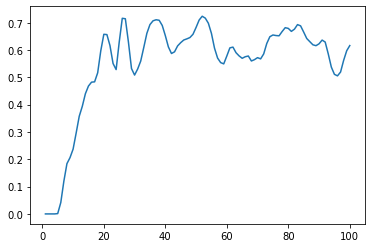

In [15]:
tsr=load_data_mat(f"BP_Timeseries/sub55_EPI_BPaal_timeseries.mat")
time_series=zscore(tsr,axis=0)
hyp_ts=hyper_vector(time_series,indifference_value,length)   
plt.plot(range(1,length+1),hyp_ts)
plt.show()

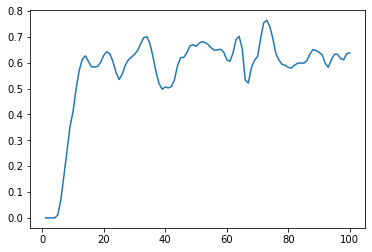

In [18]:
tsr=load_data_mat(f"BP_Timeseries/sub5_EPI_BPaal_timeseries.mat")
time_series=zscore(tsr,axis=0)
hyp_ts=hyper_vector(time_series,indifference_value,length)   
plt.plot(range(1,length+1),hyp_ts)
plt.show()

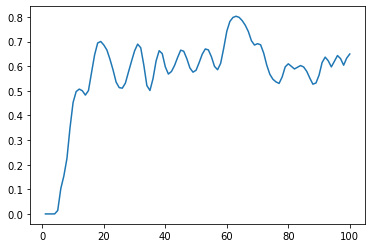

In [19]:
tsr=load_data_mat(f"BP_Timeseries/sub15_EPI_BPaal_timeseries.mat")
time_series=zscore(tsr,axis=0)
hyp_ts=hyper_vector(time_series,indifference_value,length)   
plt.plot(range(1,length+1),hyp_ts)
plt.show()

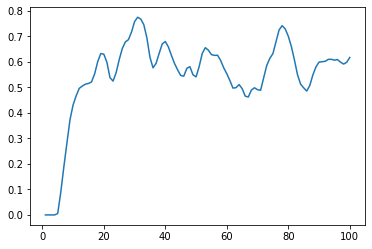

In [16]:
tsr=load_data_mat(f"HC_Timeseries/sub2_EPI_HCaal_timeseries.mat")
time_series=zscore(tsr,axis=0)
hyp_ts=hyper_vector(time_series,indifference_value,length)   
plt.plot(range(1,length+1),hyp_ts)
plt.show()

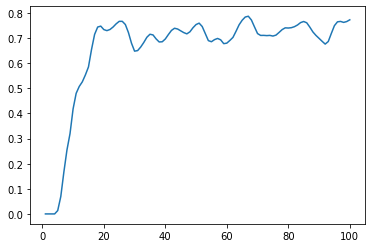

In [17]:
tsr=load_data_mat(f"HC_Timeseries/sub24_EPI_HCaal_timeseries.mat")
time_series=zscore(tsr,axis=0)
hyp_ts=hyper_vector(time_series,indifference_value,length)   
plt.plot(range(1,length+1),hyp_ts)
plt.show()

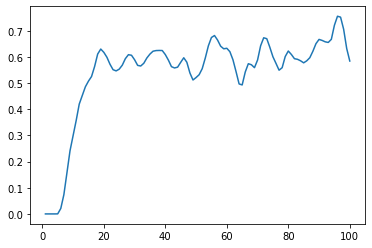

In [20]:
tsr=load_data_mat(f"HC_Timeseries/sub14_EPI_HCaal_timeseries.mat")
time_series=zscore(tsr,axis=0)
hyp_ts=hyper_vector(time_series,indifference_value,length)   
plt.plot(range(1,length+1),hyp_ts)
plt.show()

In [21]:
# parameters
indifference_value=0.05
length=100

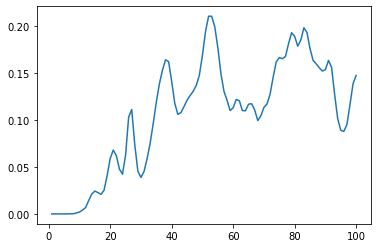

In [22]:
# WITHOUT Z SCORING

time_series=load_data_mat(f"BP_Timeseries/sub55_EPI_BPaal_timeseries.mat")
hyp_ts=hyper_vector(time_series,indifference_value,length)   
plt.plot(range(1,length+1),hyp_ts)
plt.show()

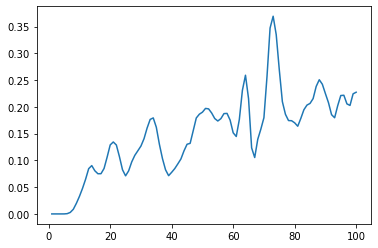

In [23]:
time_series=load_data_mat(f"BP_Timeseries/sub5_EPI_BPaal_timeseries.mat")
hyp_ts=hyper_vector(time_series,indifference_value,length)   
plt.plot(range(1,length+1),hyp_ts)
plt.show()

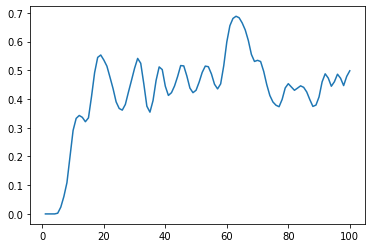

In [24]:
time_series=load_data_mat(f"BP_Timeseries/sub15_EPI_BPaal_timeseries.mat")
hyp_ts=hyper_vector(time_series,indifference_value,length)   
plt.plot(range(1,length+1),hyp_ts)
plt.show()

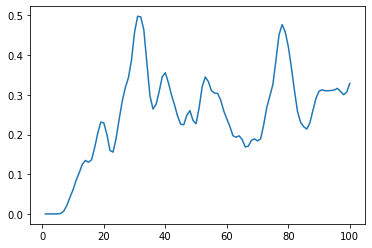

In [26]:
time_series=load_data_mat(f"HC_Timeseries/sub2_EPI_HCaal_timeseries.mat")
hyp_ts=hyper_vector(time_series,indifference_value,length)   
plt.plot(range(1,length+1),hyp_ts)
plt.show()

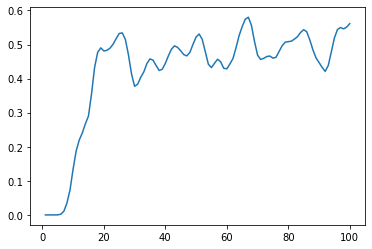

In [27]:
time_series=load_data_mat(f"HC_Timeseries/sub24_EPI_HCaal_timeseries.mat")
hyp_ts=hyper_vector(time_series,indifference_value,length)   
plt.plot(range(1,length+1),hyp_ts)
plt.show()

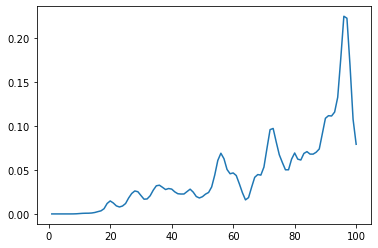

In [28]:
time_series=load_data_mat(f"HC_Timeseries/sub14_EPI_HCaal_timeseries.mat")
hyp_ts=hyper_vector(time_series,indifference_value,length)   
plt.plot(range(1,length+1),hyp_ts)
plt.show()